## Load Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [4]:
date = "2021_10_03"
trial = 1

In [5]:
datadir = 'sim_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\devel\behavioural-cloning\sim_data\IMG\center_2021_10_03_10_41_53_477.jpg,D:\devel\behavioural-cloning\sim_data\IMG\left_2021_10_03_10_41_53_477.jpg,D:\devel\behavioural-cloning\sim_data\IMG\right_2021_10_03_10_41_53_477.jpg,0.0,0.0,0,10.53699
1,D:\devel\behavioural-cloning\sim_data\IMG\center_2021_10_03_10_41_53_535.jpg,D:\devel\behavioural-cloning\sim_data\IMG\left_2021_10_03_10_41_53_535.jpg,D:\devel\behavioural-cloning\sim_data\IMG\right_2021_10_03_10_41_53_535.jpg,0.0,0.0,0,10.45199
2,D:\devel\behavioural-cloning\sim_data\IMG\center_2021_10_03_10_41_53_611.jpg,D:\devel\behavioural-cloning\sim_data\IMG\left_2021_10_03_10_41_53_611.jpg,D:\devel\behavioural-cloning\sim_data\IMG\right_2021_10_03_10_41_53_611.jpg,0.0,0.0,0,10.36766
3,D:\devel\behavioural-cloning\sim_data\IMG\center_2021_10_03_10_41_53_679.jpg,D:\devel\behavioural-cloning\sim_data\IMG\left_2021_10_03_10_41_53_679.jpg,D:\devel\behavioural-cloning\sim_data\IMG\right_2021_10_03_10_41_53_679.jpg,0.0,0.0,0,10.30486
4,D:\devel\behavioural-cloning\sim_data\IMG\center_2021_10_03_10_41_53_756.jpg,D:\devel\behavioural-cloning\sim_data\IMG\left_2021_10_03_10_41_53_756.jpg,D:\devel\behavioural-cloning\sim_data\IMG\right_2021_10_03_10_41_53_756.jpg,0.0,0.0,0,10.22173


## Prepare Data

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_10_03_10_41_53_477.jpg,left_2021_10_03_10_41_53_477.jpg,right_2021_10_03_10_41_53_477.jpg,0.0,0.0,0,10.53699
1,center_2021_10_03_10_41_53_535.jpg,left_2021_10_03_10_41_53_535.jpg,right_2021_10_03_10_41_53_535.jpg,0.0,0.0,0,10.45199
2,center_2021_10_03_10_41_53_611.jpg,left_2021_10_03_10_41_53_611.jpg,right_2021_10_03_10_41_53_611.jpg,0.0,0.0,0,10.36766
3,center_2021_10_03_10_41_53_679.jpg,left_2021_10_03_10_41_53_679.jpg,right_2021_10_03_10_41_53_679.jpg,0.0,0.0,0,10.30486
4,center_2021_10_03_10_41_53_756.jpg,left_2021_10_03_10_41_53_756.jpg,right_2021_10_03_10_41_53_756.jpg,0.0,0.0,0,10.22173


total data: 2199


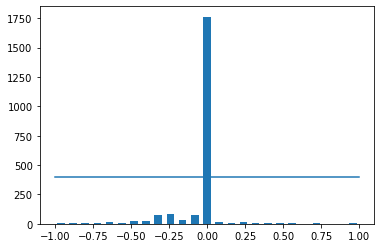

In [6]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))

In [7]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 1363
remaining: 836


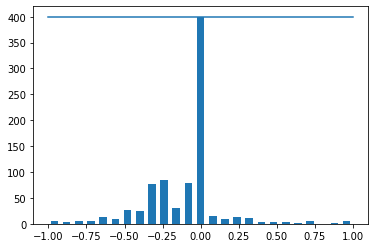

In [8]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[1])

center      center_2021_10_03_10_41_54_376.jpg
left          left_2021_10_03_10_41_54_376.jpg
right        right_2021_10_03_10_41_54_376.jpg
steering                                  -0.2
throttle                              0.510941
reverse                                      0
speed                                 10.11214
Name: 12, dtype: object


In [9]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [10]:
image_paths, steerings

(array(['sim_data/IMG\\center_2021_10_03_10_41_53_477.jpg',
        'sim_data/IMG\\left_2021_10_03_10_41_53_477.jpg',
        'sim_data/IMG\\right_2021_10_03_10_41_53_477.jpg', ...,
        'sim_data/IMG\\center_2021_10_03_10_44_53_038.jpg',
        'sim_data/IMG\\left_2021_10_03_10_44_53_038.jpg',
        'sim_data/IMG\\right_2021_10_03_10_44_53_038.jpg'], dtype='<U47'),
 array([ 0.  ,  0.15, -0.15, ...,  0.  ,  0.15, -0.15]))

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 2006
Valid Samples: 502


Text(0.5, 1.0, 'Validation set')

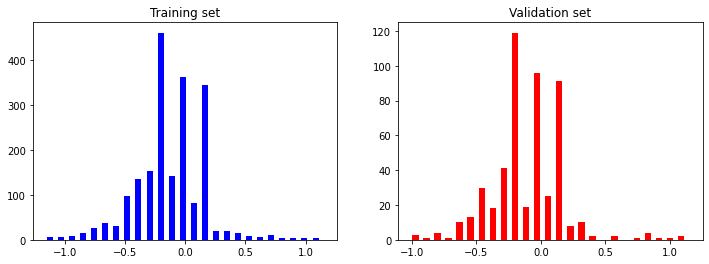

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Preprocessing Data

In [7]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed image')

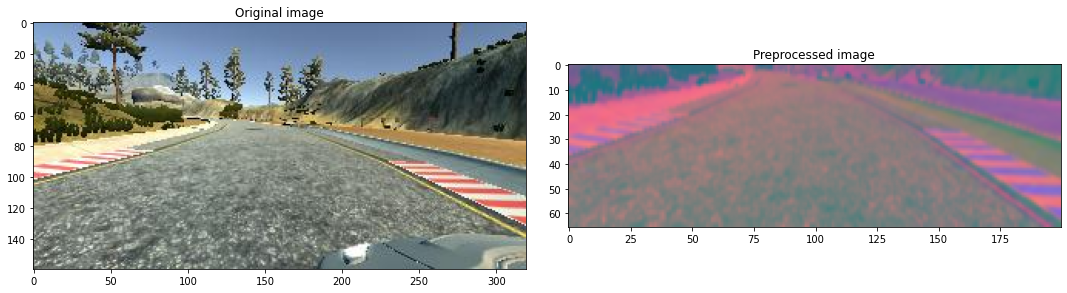

In [11]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed image')

In [16]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(2006, 66, 200, 3)


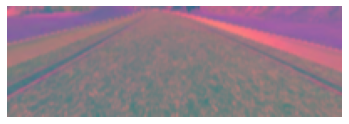

In [17]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

## NVIDIA Model

In [20]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, 5, 2, input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, 5, 2, activation='elu'))
  model.add(Conv2D(48, 5, 2, activation='elu'))
  model.add(Conv2D(64, 3, activation='elu'))
  
  model.add(Conv2D(64, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [21]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle = 1)

Epoch 1/30
21/21 [==============================] - 16s 524ms/step - loss: 0.5364 - val_loss: 0.2765
Epoch 2/30
21/21 [==============================] - 12s 555ms/step - loss: 0.1178 - val_loss: 0.0744
Epoch 3/30
21/21 [==============================] - 10s 452ms/step - loss: 0.0770 - val_loss: 0.0726
Epoch 4/30
21/21 [==============================] - 11s 516ms/step - loss: 0.0750 - val_loss: 0.0713
Epoch 5/30
21/21 [==============================] - 8s 402ms/step - loss: 0.0727 - val_loss: 0.0710
Epoch 6/30
21/21 [==============================] - 8s 374ms/step - loss: 0.0688 - val_loss: 0.0704
Epoch 7/30
21/21 [==============================] - 8s 383ms/step - loss: 0.0681 - val_loss: 0.0646
Epoch 8/30
21/21 [==============================] - 8s 362ms/step - loss: 0.0677 - val_loss: 0.0665
Epoch 9/30
21/21 [==============================] - 9s 411ms/step - loss: 0.0641 - val_loss: 0.0672
Epoch 10/30
21/21 [==============================] - 8s 398ms/step - loss: 0.0640 - val_loss: 0.

Text(0.5, 0, 'Epoch')

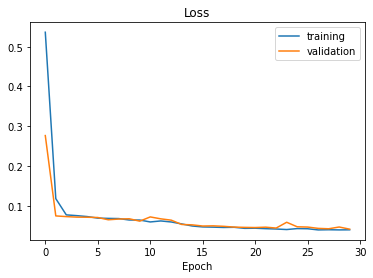

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

## Save and load Keras models

https://www.tensorflow.org/guide/keras/save_and_serialize


In [27]:
mdl = 'model-'+date+'-'+str(trial)
model.save("models/"+mdl)
print(f"Model {mdl} saved!")

INFO:tensorflow:Assets written to: models/model-2021_10_03-1\assets
Model model-2021_10_03-1 saved!


[**Keras H5 Format**](https://www.tensorflow.org/guide/keras/save_and_serialize#keras_h5_format)

Keras also supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel

In [28]:
model.save("models/"+mdl+".h5")
print(f"{mdl}.h5 saved!")

model-2021_10_03-1.h5 saved!


## Test model

In [6]:
from keras.models import load_model
mdl = 'model-'+date+'-'+str(trial)
model = load_model("models/"+mdl+".h5")

In [7]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Steering: real 0.0 - predicted -0.0653814971446991


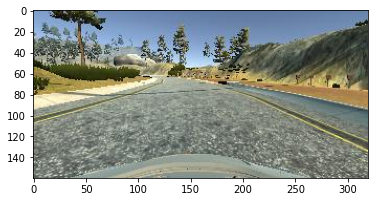

In [19]:
i = 42
image = data['center'].loc[i]
preprocessed_image = img_preprocess(image) # driving_log not preprocessed, else need to add datadir+"/IMG/"+image

original_image = mpimg.imread(image)
plt.imshow(original_image)

input_image = np.array([preprocessed_image])
steering_angle = float(model.predict(input_image))

print("Steering: real "+str(data['steering'].loc[i])+" - predicted "+str(steering_angle))



In [20]:
predicted_angles = [float(model.predict(np.array([img_preprocess(data['center'].loc[i])]))) for i in range(len(data))]


In [29]:
pd.DataFrame(predicted_angles).to_csv("predicted_angles-"+date+".csv",index=False)

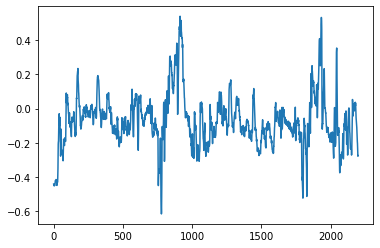

In [21]:
plt.plot(predicted_angles)

<AxesSubplot:>

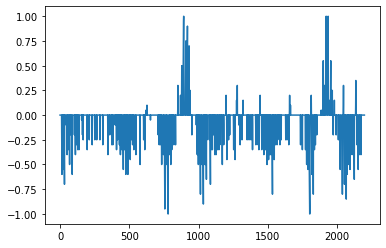

In [22]:
data['steering'].plot()